In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
from flowprintOptimal.sekigo.modeling.neuralNetworks import TransformerGenerator,CNNNetwork2D,Predictor
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer,OODTrainer
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.utils.commons import augmentData
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
import torch.nn as nn
import torch.nn.functional as F
from flowprintOptimal.sekigo.modeling.loggers import Logger
from flowprintOptimal.sekigo.modeling.neuralNetworks import NeuralNetwork
import pandas as pd

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, root, label_to_index = None,train=True, ood=False, transform=None, download=True):
        self.train = train
        self.ood = ood
        self.label_to_index = label_to_index
        if self.ood:
            self.mnist_data = datasets.MNIST(root=root, train=train, transform=transform, download=download)
            self.filter_digits([6, 7, 8, 9])  # Filter out digits 6 to 9 for OOD dataset
            self.label_to_index = {6:0,7:1,8:2,9:3}
        else:
            self.mnist_data = datasets.MNIST(root=root, train=train, transform=transform, download=download)
            self.filter_digits([0,1,2,3,4,5])
            self.label_to_index = {0:0,1:1,2:2,3:3,4:4,5:5}
           

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        data_point = self.mnist_data[idx]
        #torch.clamp(data_point[0],min= 0,max= 1)
        return dict(data = data_point[0], label = self.label_to_index[data_point[1]])

    def filter_digits(self, digits):
        filtered_indices = [i for i, (_, label) in enumerate(self.mnist_data) if label in digits]
        self.mnist_data = torch.utils.data.Subset(self.mnist_data, filtered_indices)

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

transform_non_train = transforms.Compose([
    transforms.ToTensor(),
])

# Create custom MNIST datasets
train_dataset = MNISTDataset(root='./data', train=True, transform=transform)
test_dataset = MNISTDataset(root='./data', train=False, ood=False, transform=transform_non_train)
ood_dataset = MNISTDataset(root='./data', train=True, ood=True, transform= transform_non_train)




In [3]:
discriminator = CNNNetwork2D(in_channels= 1,num_filters= 32,kernel_sizes= [5,9,13],output_dim= 1)
generator = TransformerGenerator(output_dim= 16,random_dim= 4,seq_len= 49,embedding_dim= 64,num_heads= 4,num_layers= 5,is_img= True,device= device)
classifier = CNNNetwork2D(in_channels= 1,num_filters= 8,kernel_sizes= [5,9,11],output_dim= len(train_dataset.label_to_index) + 1)
logger = Logger(name= "OOD_GAN")
logger.default_step_size = 200

In [4]:
#trainer = GANTrainer(generator= generator,discriminator= discriminator,logger= logger,device= device)
trainer = OODTrainer(classifier= classifier,generator=generator,
                     discriminator= discriminator,logger= logger,device= device,n= 2,classifier_only= False)

In [5]:
trainer.train(train_dataset= train_dataset,batch_size= 128,n_critic= 3,epochs= 20,ood_dataset=ood_dataset,test_dataset=test_dataset,
              gp_weight= 1,lr_discriminator= .0001, lr_generator= .0001)

OOD_GAN ---- 200 metric classifier_loss = 2.0444187831878664
OOD_GAN ---- 200 metric classifier_aug_loss = 0.7131825494673103
OOD_GAN ---- 200 metric 0_discriminator_loss = -19.528481563031672
OOD_GAN ---- 200 metric 0_cost_wd = -32.252374032586815
OOD_GAN ---- 200 metric 0_gp_loss = 12.723892482817172
OOD_GAN ---- 200 metric 1_discriminator_loss = -10.212002573013306
OOD_GAN ---- 200 metric 1_cost_wd = -16.695071825683115
OOD_GAN ---- 200 metric 1_gp_loss = 6.483069259226323
OOD_GAN ---- 400 metric classifier_loss = 1.2808520263433456
OOD_GAN ---- 400 metric classifier_aug_loss = 0.13789479712431785
OOD_GAN ---- 400 metric 0_discriminator_loss = -13.93965654373169
OOD_GAN ---- 400 metric 0_cost_wd = -21.58224826812744
OOD_GAN ---- 400 metric 0_gp_loss = 7.642591705322266
OOD_GAN ---- 400 metric 1_discriminator_loss = -6.954556496143341
OOD_GAN ---- 400 metric 1_cost_wd = -10.18110936164856
OOD_GAN ---- 400 metric 1_gp_loss = 3.226552874445915


In [ ]:
generator = trainer.generator.eval()

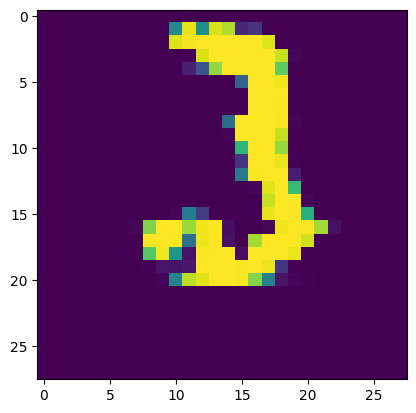

In [ ]:
with torch.no_grad():
    z = generator.generateRandomZ(batch_size= 1).to(device)
    out = generator(z)
    out = out.cpu().numpy()[0][0]
    plt.imshow(out)